In [2]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE


import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.optim import AdamW
import torchvision
import torchvision.transforms as transforms
%matplotlib inline
# Retina
%config InlineBackend.figure_format = 'retina'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
device

device(type='mps')

In [4]:
def make_diag_zero(mat):

    for i in range(mat.shape[0]):

        mat[i][i] = 0
    
    return mat

#### Download data

In [5]:
root = "./data/"

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root=root, train=True,
                                         download=False, transform=transform)
test_dataset = torchvision.datasets.MNIST(root=root, train=False,
                                        download=False, transform=transform)

#### Data preprocessing

In [6]:
number_samples = [torch.where(train_dataset.targets==i)[0] for i in range(10)]

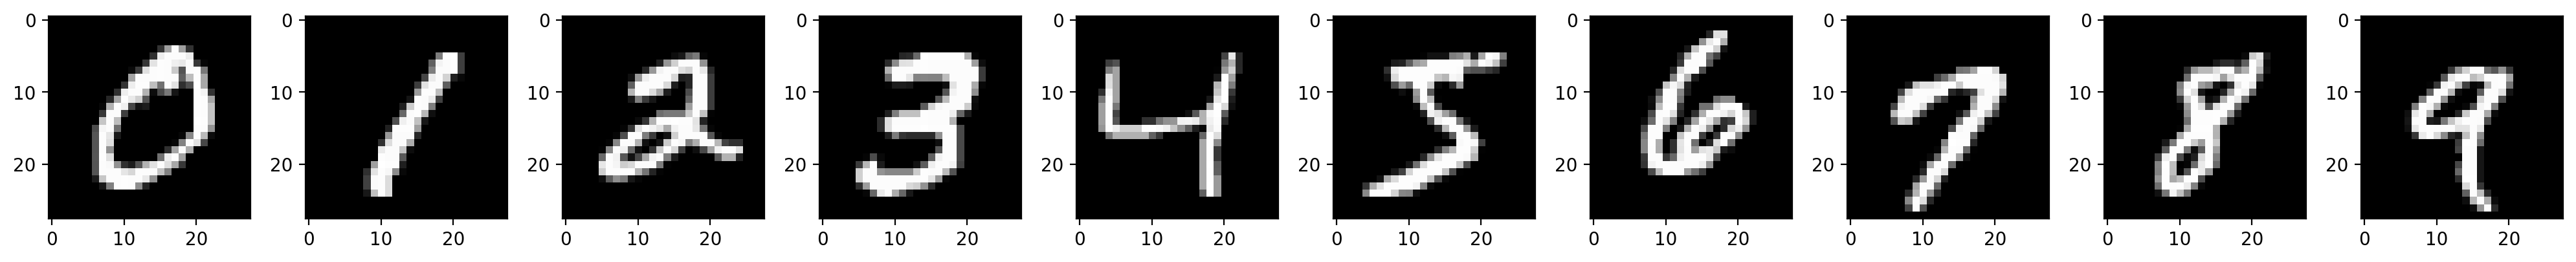

In [7]:
fig, axs = plt.subplots(1, 10, figsize=(20,10))

for i in range(10):

    axs[i].imshow(train_dataset.data[number_samples[i][0]], cmap="grey")

plt.tight_layout()

In [8]:
X_train = train_dataset.data.reshape((len(train_dataset), -1))
y_train = train_dataset.targets.to(torch.float32)

X_test = test_dataset.data.reshape((len(test_dataset), -1))
y_test = test_dataset.targets.to(torch.float32)

In [9]:
scaler = StandardScaler()
X_train_scaled = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
X_test_scaled = torch.tensor(scaler.transform(X_test), dtype=torch.float32)

In [10]:
X_train_scaled.shape

torch.Size([60000, 784])

#### Model

In [85]:
class Model1(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.Linear1 = torch.nn.Linear(784, 1000, bias=True, dtype=torch.float32)
        self.Linear2 = torch.nn.Linear(1000, 100, bias=True, dtype=torch.float32)
        self.Linear3 = torch.nn.Linear(100, 10, bias=True, dtype=torch.float32)

        self.lrelu = torch.nn.LeakyReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.dropout = torch.nn.Dropout(0.4)

    def forward(self, X):

        X1 = self.dropout(self.lrelu(self.Linear1(X)))
        X2 = self.dropout(self.lrelu(self.Linear2(X1)))
        X3 = self.sigmoid(self.Linear3(X2))

        return (X1, X2, X3)


In [73]:
class Model2(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.Linear1 = torch.nn.Linear(784, 1000, bias=True, dtype=torch.float32)
        self.Linear2 = torch.nn.Linear(1000, 500, bias=True, dtype=torch.float32)
        self.Linear3 = torch.nn.Linear(500, 200, bias=True, dtype=torch.float32)
        self.Linear4 = torch.nn.Linear(200, 100, bias=True, dtype=torch.float32)
        self.Linear5 = torch.nn.Linear(100, 10, bias=True, dtype=torch.float32)

        self.lrelu = torch.nn.LeakyReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.dropout = torch.nn.Dropout(0.4)

    def forward(self, X):

        X1 = self.dropout(self.lrelu(self.Linear1(X)))
        X2 = self.dropout(self.lrelu(self.Linear2(X1)))
        X3 = self.dropout(self.lrelu(self.Linear3(X2)))
        X4 = self.dropout(self.lrelu(self.Linear4(X3)))
        X5 = self.sigmoid(self.Linear5(X4))

        return (X1, X2, X5)


In [86]:
model = Model1().to(device)

#### Training

In [87]:
torch.compile(model)

OptimizedModule(
  (_orig_mod): Model1(
    (Linear1): Linear(in_features=784, out_features=1000, bias=True)
    (Linear2): Linear(in_features=1000, out_features=100, bias=True)
    (Linear3): Linear(in_features=100, out_features=10, bias=True)
    (lrelu): LeakyReLU(negative_slope=0.01)
    (sigmoid): Sigmoid()
    (dropout): Dropout(p=0.4, inplace=False)
  )
)

In [88]:
loss_fn = torch.nn.CrossEntropyLoss()

opt = AdamW(model.parameters(), lr=0.001)

batch_size = 10000
data_size = X_train.shape[0]

for epoch in range(500):
    loss_ = torch.zeros(data_size//batch_size)

    for iter in range(data_size//batch_size):

        x = X_train_scaled[iter*batch_size: (iter+1)*batch_size].to(device)
        y = y_train[iter*batch_size: (iter+1)*batch_size].to(device)

        pred = model(x)
        loss = loss_fn(pred[-1], y)

        loss_[iter] = loss.item()

        loss.backward()
        opt.step()
        opt.zero_grad()

    if epoch%50==0:
        print(f"epoch {epoch} ---> loss: {loss_.mean()}")


epoch 0 ---> loss: 2.1561713218688965
epoch 50 ---> loss: 1.4834164381027222
epoch 100 ---> loss: 1.4711394309997559
epoch 150 ---> loss: 1.467076301574707
epoch 200 ---> loss: 1.4655380249023438
epoch 250 ---> loss: 1.4642966985702515
epoch 300 ---> loss: 1.4639233350753784
epoch 350 ---> loss: 1.463427186012268
epoch 400 ---> loss: 1.463164210319519
epoch 450 ---> loss: 1.4629207849502563


#### Testing

In [89]:
model.eval()

with torch.no_grad():

    y_pred_mlp = model(X_test_scaled.to(device))

y_pred_mlp = torch.argmax(y_pred_mlp[-1], dim=1).detach().cpu()

Accuracy: 0.9816
Precision: 0.9816
Recall: 0.9816
F1 Score: 0.9816


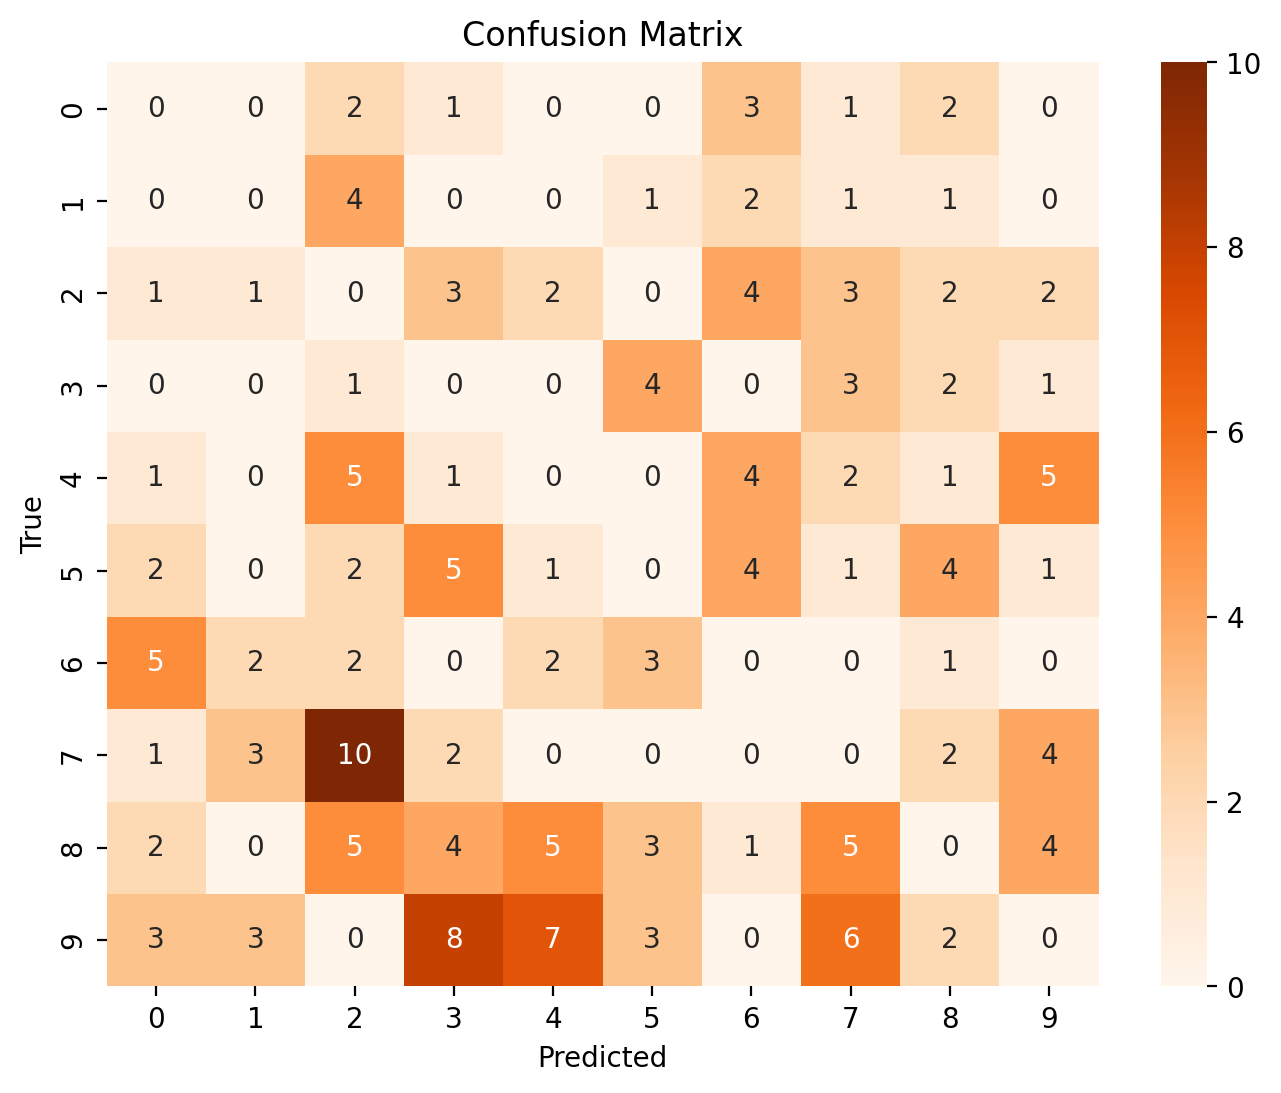

In [90]:
print(f"Accuracy: {accuracy_score(y_pred_mlp, y_test)}")
print(f"Precision: {precision_score(y_pred_mlp, y_test, average='micro')}")
print(f"Recall: {recall_score(y_pred_mlp, y_test, average='micro')}")
print(f"F1 Score: {f1_score(y_pred_mlp, y_test, average='micro')}")

cm = make_diag_zero(confusion_matrix(y_test, y_pred_mlp))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Random Forest

In [91]:
random_forest_classifier = RandomForestClassifier(n_estimators=100)

random_forest_classifier.fit(X_train_scaled, y_train)
y_pred_rf = random_forest_classifier.predict(X_test_scaled)

Accuracy: 0.9698
Precision: 0.9698
Recall: 0.9698
F1 Score: 0.9698


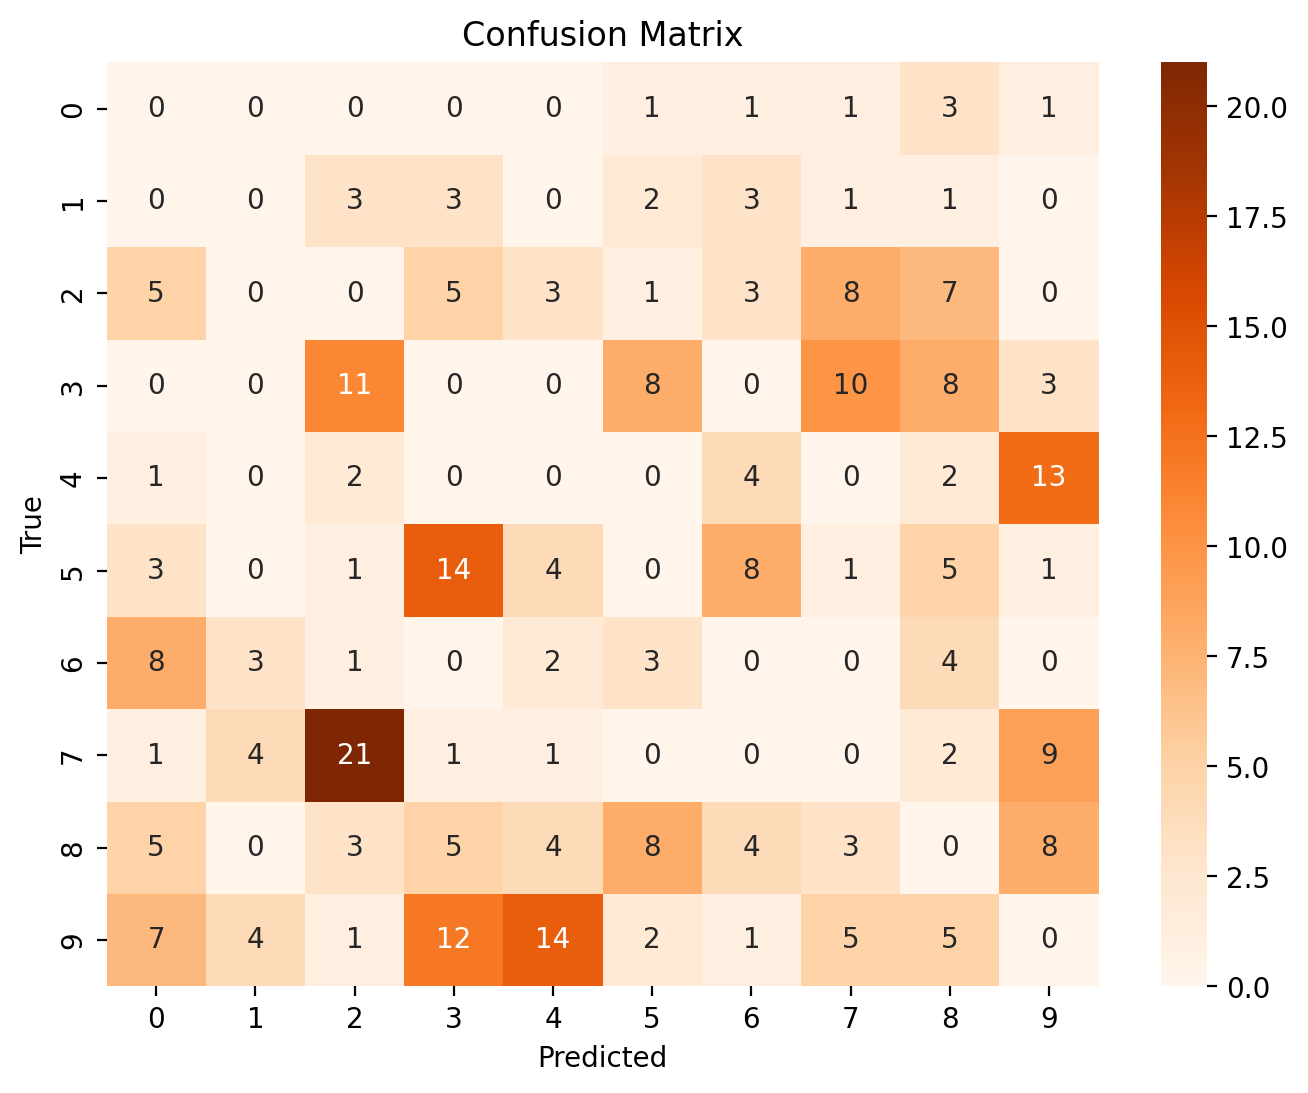

In [92]:
print(f"Accuracy: {accuracy_score(y_pred_rf, y_test)}")
print(f"Precision: {precision_score(y_pred_rf, y_test, average='micro')}")
print(f"Recall: {recall_score(y_pred_rf, y_test, average='micro')}")
print(f"F1 Score: {f1_score(y_pred_rf, y_test, average='micro')}")

cm = make_diag_zero(confusion_matrix(y_test, y_pred_rf))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Logistic regression

In [93]:
log_reg = LogisticRegression(solver='saga', max_iter=100, multi_class='multinomial', n_jobs=-1)

log_reg.fit(X_train_scaled, y_train)

/Users/saileshpanda/Desktop/IITGN/.AI/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/saileshpanda/Desktop/IITGN/.AI/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(multi_class='multinomial', n_jobs=-1, solver='saga')

In [94]:
y_pred_lr = log_reg.predict(X_test_scaled)

Accuracy: 0.9223
Precision: 0.9223
Recall: 0.9223
F1 Score: 0.9223


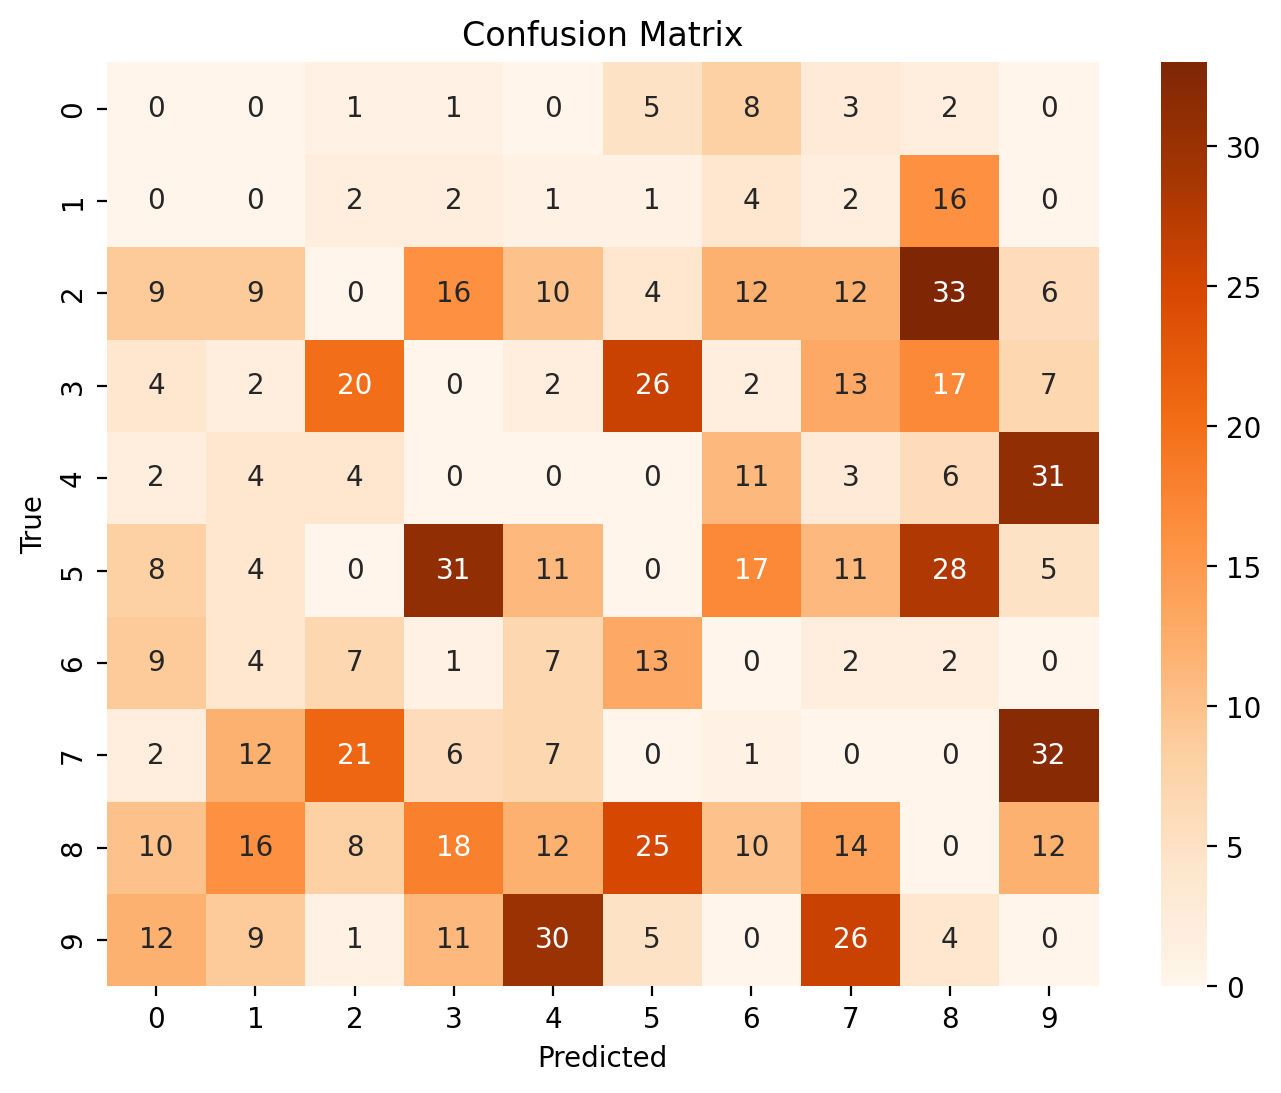

In [95]:
print(f"Accuracy: {accuracy_score(y_pred_lr, y_test)}")
print(f"Precision: {precision_score(y_pred_lr, y_test, average='micro')}")
print(f"Recall: {recall_score(y_pred_lr, y_test, average='micro')}")
print(f"F1 Score: {f1_score(y_pred_lr, y_test, average='micro')}")

cm = make_diag_zero(confusion_matrix(y_test, y_pred_lr))
#cm = np.log1p(confusion_matrix(y_test, y_pred_lr))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, #fmt="d",
             cmap="Oranges",
             xticklabels=range(10),
             yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

#### TSNE

In [97]:
with torch.no_grad():
    y = model(X_test_scaled.to(device))

In [98]:
tsne = TSNE(n_components=2, perplexity=3)
trained_y = tsne.fit_transform(y[1].squeeze(0).cpu())

In [118]:
model2 = Model1()
model2.eval()
with torch.no_grad():

    untrained_pred = model2(X_test_scaled)

untrained_tsne = TSNE(n_components=2, perplexity=3)
untrained_y = untrained_tsne.fit_transform(untrained_pred[1].squeeze(0).cpu())

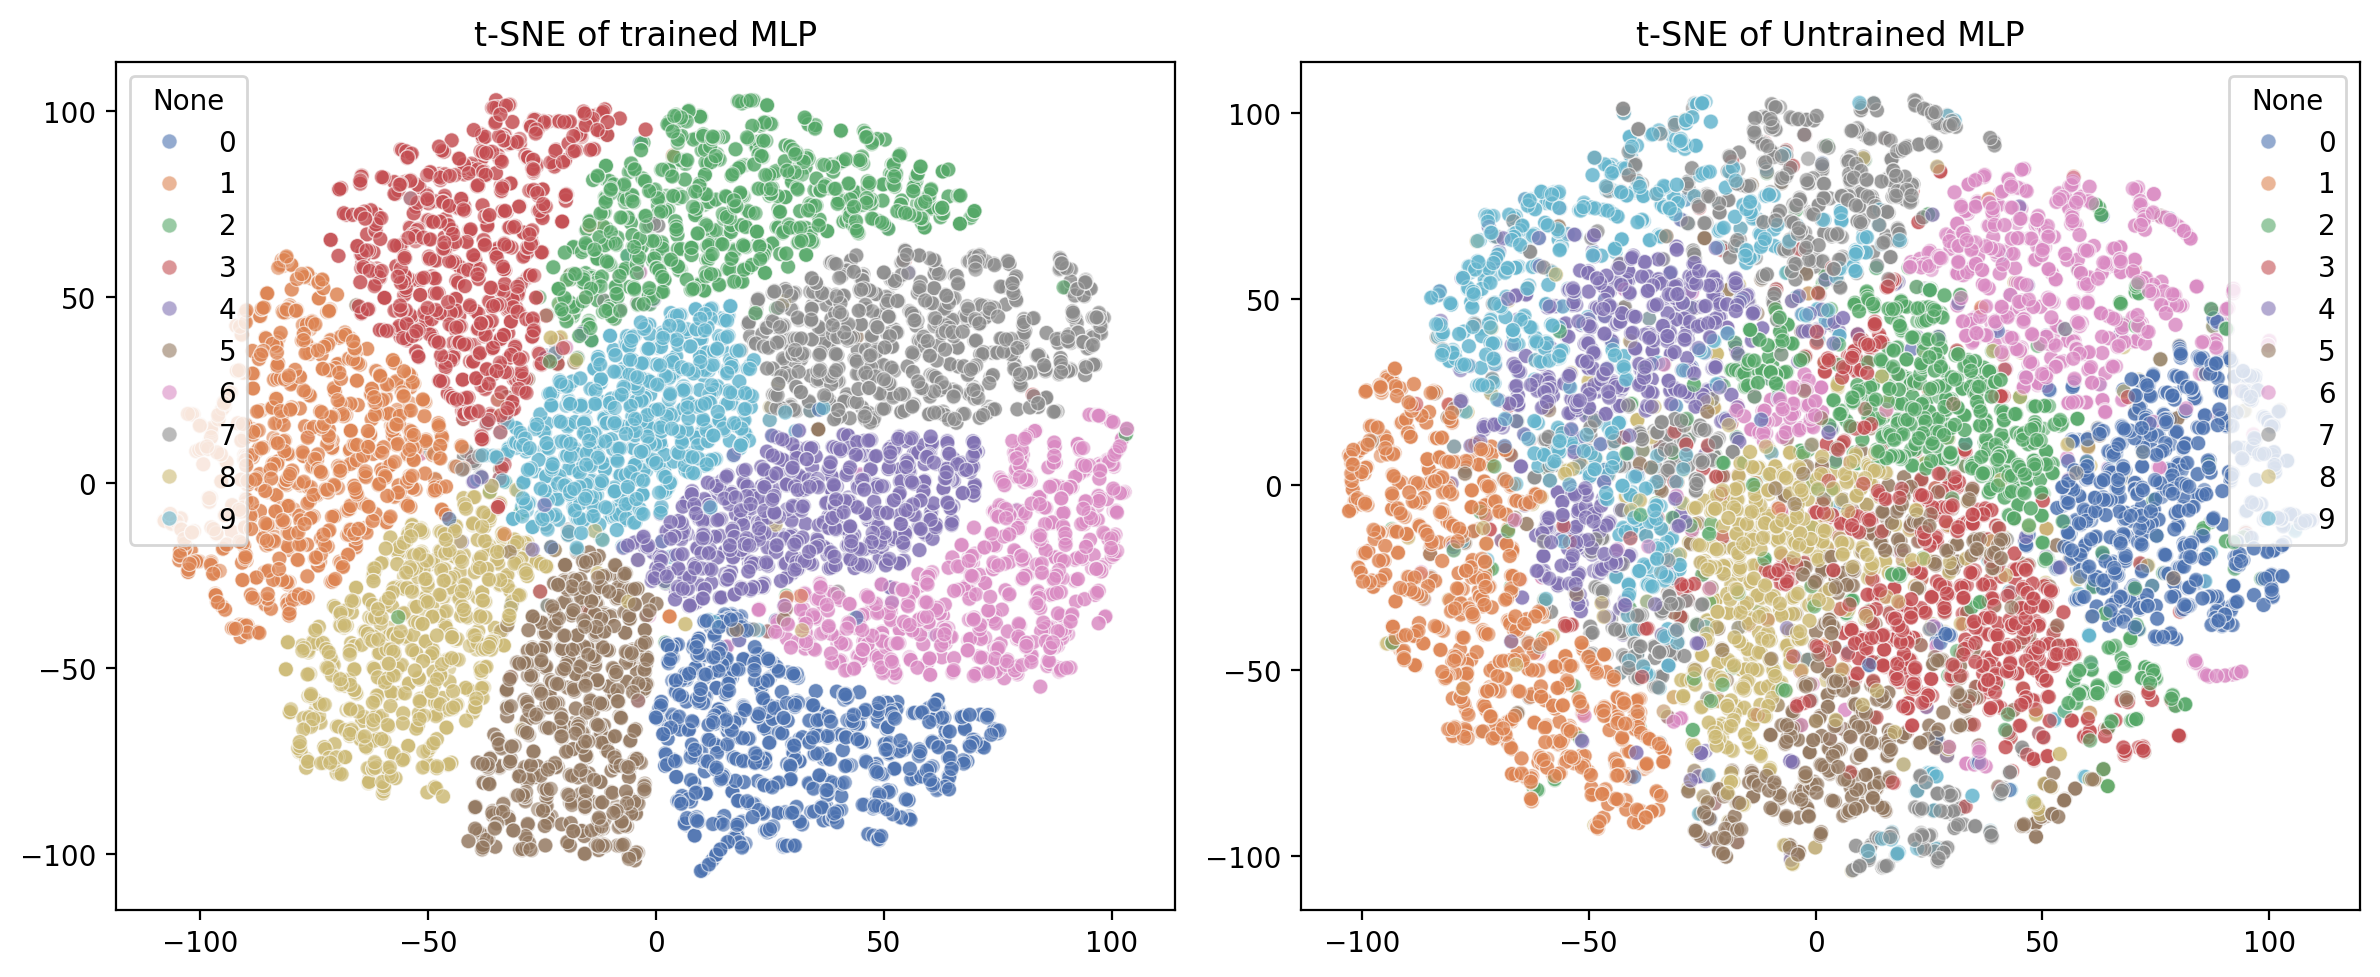

In [121]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))


sns.scatterplot(x=trained_y[:,0], y=trained_y[:,1], hue=y_test.to(int), palette='deep',
                            alpha=0.6,
                            s=30, ax=axs[0])
axs[0].set_title("t-SNE of trained MLP")
sns.scatterplot(x=untrained_y[:,0], y=untrained_y[:,1], hue=y_test.to(int), palette='deep',
                            alpha=0.6,
                            s=30, ax=axs[1])
axs[1].set_title("t-SNE of Untrained MLP")

plt.tight_layout()

### Fashion MNIST

In [109]:
fashion_mnist_test_dataset = torchvision.datasets.FashionMNIST(root=root, train=False,
                                        download=True, transform=transform)

In [110]:
fashion_mnist_test_dataset.data.shape

torch.Size([10000, 28, 28])

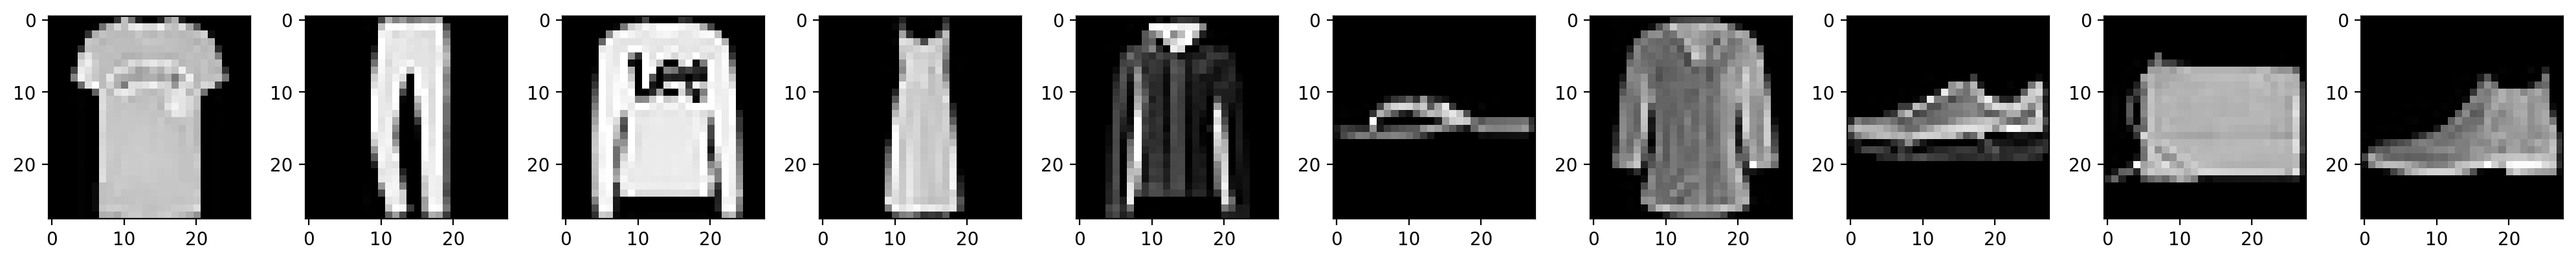

In [111]:
number_samples = [torch.where(fashion_mnist_test_dataset.targets==i)[0] for i in range(10)]

fig, axs = plt.subplots(1, 10, figsize=(20,10))

for i in range(10):

    axs[i].imshow(fashion_mnist_test_dataset.data[number_samples[i][0]], cmap="grey")

plt.tight_layout()

In [112]:
fm_X_test = fashion_mnist_test_dataset.data.reshape((len(fashion_mnist_test_dataset), -1))
fm_y_test = fashion_mnist_test_dataset.targets.to(torch.float32)

In [113]:
fn_X_test_scaled = torch.tensor(scaler.transform(fm_X_test), dtype=torch.float32)

Accuracy: 0.1144
Precision: 0.1144
Recall: 0.1144
F1 Score: 0.1144


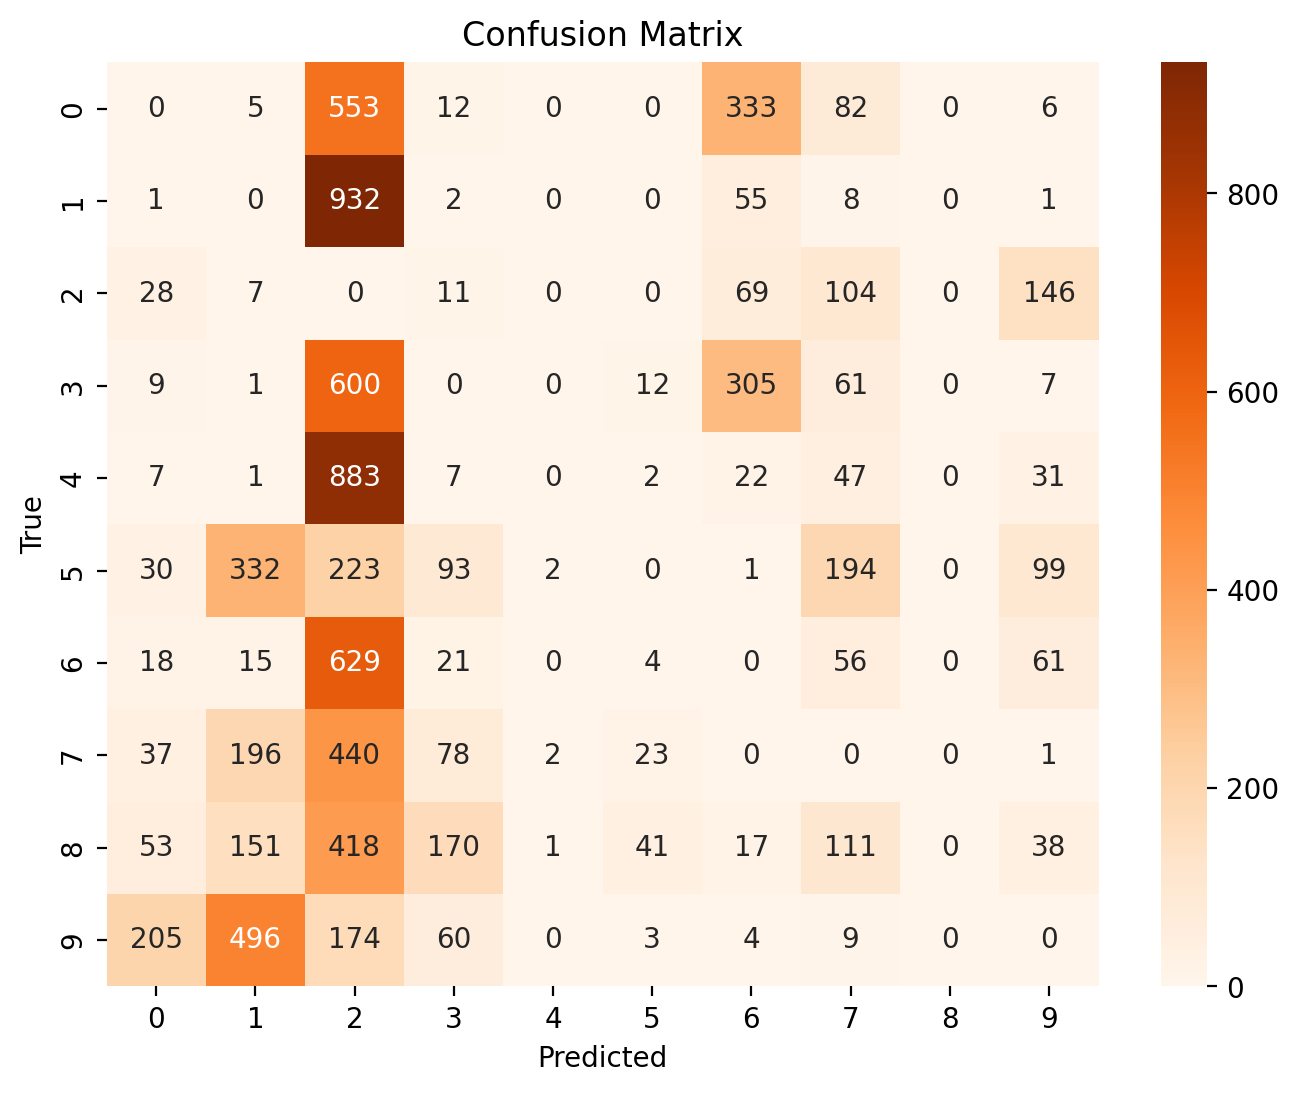

In [114]:
with torch.no_grad():

    fn_pred = model(fn_X_test_scaled.to(device))

fn_y_pred = torch.argmax(fn_pred[-1], dim=-1).cpu()
print(f"Accuracy: {accuracy_score(fn_y_pred, fm_y_test)}")
print(f"Precision: {precision_score(fn_y_pred, fm_y_test, average='micro')}")
print(f"Recall: {recall_score(fn_y_pred, fm_y_test, average='micro')}")
print(f"F1 Score: {f1_score(fn_y_pred, fm_y_test, average='micro')}")

cm = make_diag_zero(confusion_matrix(fm_y_test, fn_y_pred))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d",
             cmap="Oranges",
             xticklabels=range(10),
             yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

##### tSNE

In [115]:
fm_tsne = TSNE(n_components=2, perplexity=3)
fm_y = fm_tsne.fit_transform(fn_pred[1].squeeze(0).cpu())

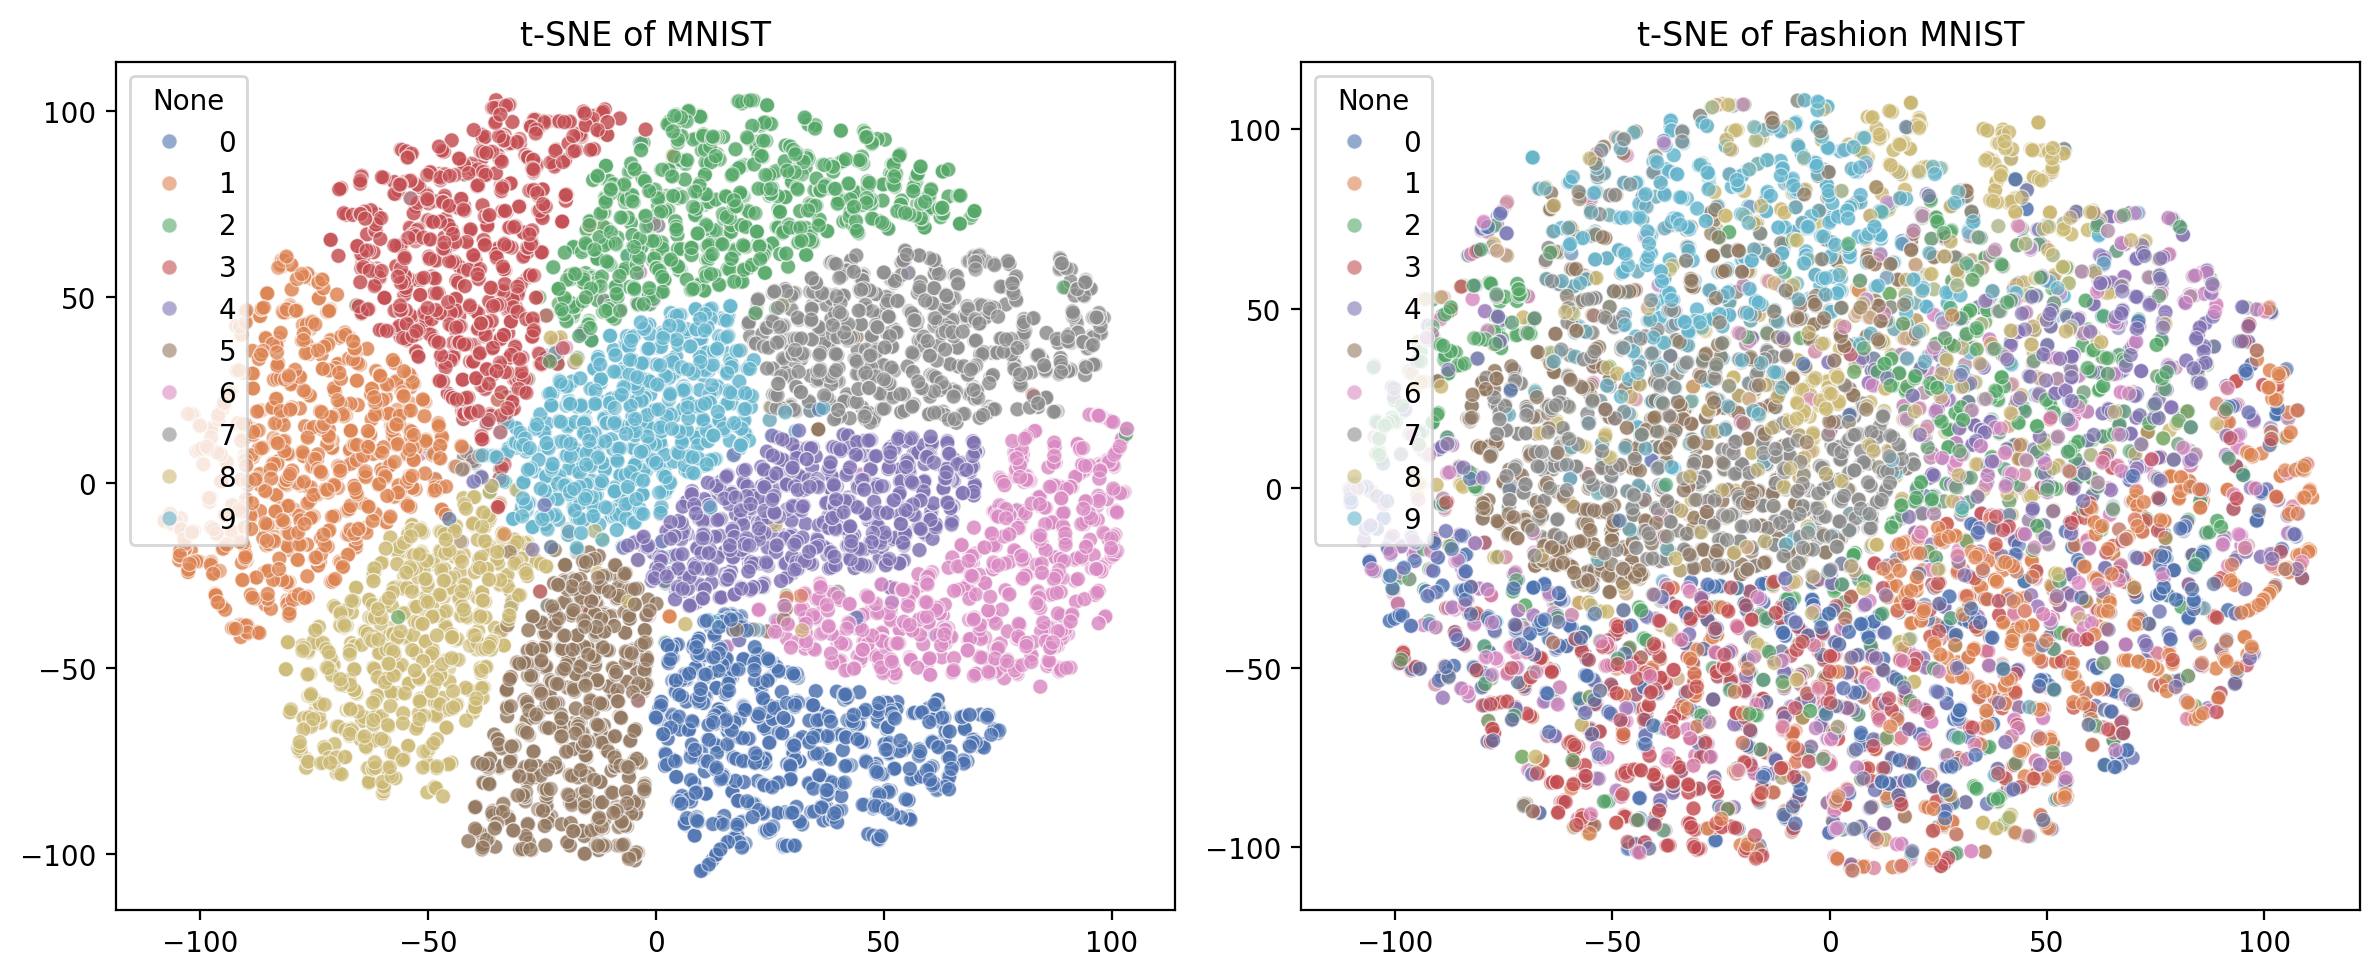

In [122]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))


sns.scatterplot(x=trained_y[:,0], y=trained_y[:,1], hue=y_test.to(int), palette='deep',
                            alpha=0.6,
                            s=30, ax=axs[0])
axs[0].set_title("t-SNE of MNIST")
sns.scatterplot(x=fm_y[:,0], y=fm_y[:,1], hue=fm_y_test.to(int), palette='deep',
                            alpha=0.6,
                            s=30, ax=axs[1])
axs[1].set_title("t-SNE of Fashion MNIST")

plt.tight_layout()